# 如何采样视频片段

本示例介绍如何从视频中采样 :term:`片段 (clips)`。片段通常指一段帧序列/批次，常作为视频模型的输入。


## 准备：下载视频与绘图工具
可直接跳到后文的采样部分。


In [1]:
from typing import Optional
import torch
import httpx

url = "https://videos.pexels.com/video-files/854132/854132-sd_640_360_25fps.mp4"
response = httpx.get(url, headers={"User-Agent": ""})
if response.status_code != 200:
    raise RuntimeError(f"Failed to download video. {response.status_code = }.")
raw_video_bytes = response.content

def plot(frames: torch.Tensor, title: Optional[str] = None):
    try:
        from torchvision.utils import make_grid
        from torchvision.transforms.v2.functional import to_pil_image
        import matplotlib.pyplot as plt
    except ImportError:
        print("Cannot plot, please run `pip install torchvision matplotlib`")
        return
    plt.rcParams["savefig.bbox"] = 'tight'
    fig, ax = plt.subplots()
    ax.imshow(to_pil_image(make_grid(frames)))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()


## 创建解码器
采样前先创建 :class:`torchcodec.decoders.VideoDecoder`。也可以传入本地文件路径。


In [2]:
from torchcodec.decoders import VideoDecoder
decoder = VideoDecoder(raw_video_bytes)


## 采样基础：随机索引采样
以 :func:`torchcodec.samplers.clips_at_random_indices` 为例，采样从随机索引开始的片段。


In [3]:
from torchcodec.samplers import clips_at_random_indices

torch.manual_seed(0)
clips = clips_at_random_indices(
    decoder,
    num_clips=5,
    num_frames_per_clip=4,
    num_indices_between_frames=3,
)
clips


FrameBatch:
  data (shape): torch.Size([5, 4, 3, 360, 640])
  pts_seconds: tensor([[11.3600, 11.4800, 11.6000, 11.7200],
        [10.2000, 10.3200, 10.4400, 10.5600],
        [ 9.8000,  9.9200, 10.0400, 10.1600],
        [ 9.6000,  9.7200,  9.8400,  9.9600],
        [ 8.4400,  8.5600,  8.6800,  8.8000]], dtype=torch.float64)
  duration_seconds: tensor([[0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400]], dtype=torch.float64)

## FrameBatch 字段说明
采样器返回 :class:`torchcodec.FrameBatch`：
- `data`：5D uint8 张量，形状为 `(num_clips, num_frames_per_clip, ...)`，`...` 为 `(C,H,W)` 或 `(H,W,C)`，取决于解码器的 `dimension_order`。
- `pts_seconds`：形状 `(num_clips, num_frames_per_clip)` 的 2D 浮点张量，给出每帧起始时间（秒）。
- `duration_seconds`：同形状的 2D 浮点张量，给出每帧持续时间（秒）。


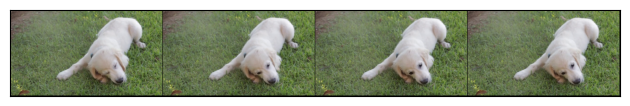

In [4]:
plot(clips[0].data)


## 片段索引与筛选
FrameBatch 支持原生 PyTorch 索引（含高阶索引），便于按条件筛选。


In [5]:
clip_starts = clips.pts_seconds[:, 0]
clip_starts


tensor([11.3600, 10.2000,  9.8000,  9.6000,  8.4400], dtype=torch.float64)

In [6]:
clips_starting_after_five_seconds = clips[clip_starts > 5]
clips_starting_after_five_seconds


FrameBatch:
  data (shape): torch.Size([5, 4, 3, 360, 640])
  pts_seconds: tensor([[11.3600, 11.4800, 11.6000, 11.7200],
        [10.2000, 10.3200, 10.4400, 10.5600],
        [ 9.8000,  9.9200, 10.0400, 10.1600],
        [ 9.6000,  9.7200,  9.8400,  9.9600],
        [ 8.4400,  8.5600,  8.6800,  8.8000]], dtype=torch.float64)
  duration_seconds: tensor([[0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400]], dtype=torch.float64)

In [7]:
every_other_clip = clips[::2]
every_other_clip


FrameBatch:
  data (shape): torch.Size([3, 4, 3, 360, 640])
  pts_seconds: tensor([[11.3600, 11.4800, 11.6000, 11.7200],
        [ 9.8000,  9.9200, 10.0400, 10.1600],
        [ 8.4400,  8.5600,  8.6800,  8.8000]], dtype=torch.float64)
  duration_seconds: tensor([[0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400]], dtype=torch.float64)

.. note:: 更自然且更高效的方式是使用采样范围参数（见后文）。

## 索引型与时间型采样器
索引型：`clips_at_random_indices`、`clips_at_regular_indices`
时间型：`clips_at_random_timestamps`、`clips_at_regular_timestamps`
两类采样器 API 类似，速度也大致可比。

.. note:: 常帧率视频下，索引型与时间型等效；可变帧率下，时间型更能保证时间维度上的均匀采样。


## 进阶参数：采样范围
仅在区间 `[sampling_range_start, sampling_range_end)` 内允许片段"开始"。注意片段的帧可超出上界，因为限制的是起始时间。


In [8]:
from torchcodec.samplers import clips_at_regular_timestamps

clips = clips_at_regular_timestamps(
    decoder,
    seconds_between_clip_starts=1,
    num_frames_per_clip=4,
    seconds_between_frames=0.5,
    sampling_range_start=2,
    sampling_range_end=5
)
clips


FrameBatch:
  data (shape): torch.Size([3, 4, 3, 360, 640])
  pts_seconds: tensor([[2.0000, 2.4800, 3.0000, 3.4800],
        [3.0000, 3.4800, 4.0000, 4.4800],
        [4.0000, 4.4800, 5.0000, 5.4800]], dtype=torch.float64)
  duration_seconds: tensor([[0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400]], dtype=torch.float64)

## 进阶参数：policy
当采样器尝试超出视频末尾时，`policy` 定义如何替换无效帧。


In [9]:
from torchcodec.samplers import clips_at_random_timestamps

end_of_video = decoder.metadata.end_stream_seconds
print(f"{end_of_video = }")

torch.manual_seed(0)
clips = clips_at_random_timestamps(
    decoder,
    num_clips=1,
    num_frames_per_clip=5,
    seconds_between_frames=0.4,
    sampling_range_start=end_of_video - 1,
    sampling_range_end=end_of_video,
    policy="repeat_last",
)
clips.pts_seconds


end_of_video = 13.8


tensor([[13.2800, 13.6800, 13.6800, 13.6800, 13.6800]], dtype=torch.float64)

默认策略 `repeat_last` 会重复最后一帧以构造片段。另一个策略是 `wrap`，会从片段开头回绕并重复前面的有效帧。


In [10]:
torch.manual_seed(0)
clips = clips_at_random_timestamps(
    decoder,
    num_clips=1,
    num_frames_per_clip=5,
    seconds_between_frames=0.4,
    sampling_range_start=end_of_video - 1,
    sampling_range_end=end_of_video,
    policy="wrap",
)
clips.pts_seconds


tensor([[13.2800, 13.6800, 13.2800, 13.6800, 13.2800]], dtype=torch.float64)

默认会自动设置 `sampling_range_end`，以避免采样器采到末尾之后的时间戳，因此多数情况下无需关注 `policy`。
